**Creating a machine learning model in order to forecast On BAse Percentage using 2016-2020 Data in order to check Model Effeciency (Predicted vs. Actual)** 

By: Roy Krishnan, Founder, Liquid Sports Lab

To briefly outline the steps I will take:  I will explore and clean the dataset, and engineer relevant predictors. Then, I will employ a formal machine-learning workflow to train an optimally-tuned model to predict OBP based on the predictors. First and foremost, is there a relationship to year over year OBP percentage? There will obviously be one over time (better players stay in the league longer), but is there one from year over year? 

In [ ]:
# How indicative of future OBP is past OBP and PA - lets run through a check with 2020 to 2021 data. 
# This helps us find a good regression model for predictions 
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy.stats import linregress

data = pd.read_csv('/Users/rohitkrishnan/Desktop/obp.csv')

obp_21 = data[["Name","OBP_21"]]
obp_20 = data[["Name", "OBP_20"]].dropna(subset=["OBP_20"])
new_df = pd.merge(obp_21, obp_20, on="Name")
# Create scatter plot with a regression
plt.figure(figsize=(12, 6))
reg_plot = sns.regplot(x='OBP_20', y='OBP_21', data=new_df, scatter_kws={'alpha': 0.5})
slope, intercept, r_value, p_value, std_err = linregress(new_df['OBP_20'], new_df['OBP_21'])
r_squared = r_value ** 2
plt.xlabel('OBP in 2020 (OBP_20)')
plt.ylabel('OBP in 2021 (OBP_21)')
plt.title('Relationship between OBP in 2020 and OBP in 2021')
plt.grid(True)
plt.text(0.3, 0.6, f'R² = {r_squared:.2f}', fontsize=12)
plt.show()
print(f'R-squared (R²) value: {r_squared:.2f}')

Using this script we check two random examples: 20-21 and 16-17, their values are 0.09 and 0.08 respectively. Showing us though there is a correlation for All Star & Hall of Fame level players, there is no guarantee an average player is going to reproduce their production year over year. Ultimately we see that elite players tend to stay good to elite, but average players have no indicator that they're able to replicate their OBP year over year.

Therefore, we then check additional variables. Using research and data from Baseball Savant from 2020 to see if we can extrapolate batted ball data into a significant predictor for On Base Percentage we use seaborn to create a correlation matrix heatmap to see if any relationships have a significant r^2 value. 

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

data = pd.read_csv('/Users/rohitkrishnan/Downloads/stats.csv')
df = pd.DataFrame(data)
subset = df.loc[:, 'on_base_percent':]
corr_matrix = subset.corr()
# Heat map plot
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", vmin=-1, vmax=1)
plt.title("Correlation Matrix Heatmap")
plt.show()

![Screenshot 2023-10-16 at 12.39.25 PM.png](<attachment:Screenshot 2023-10-16 at 12.39.25 PM.png>)
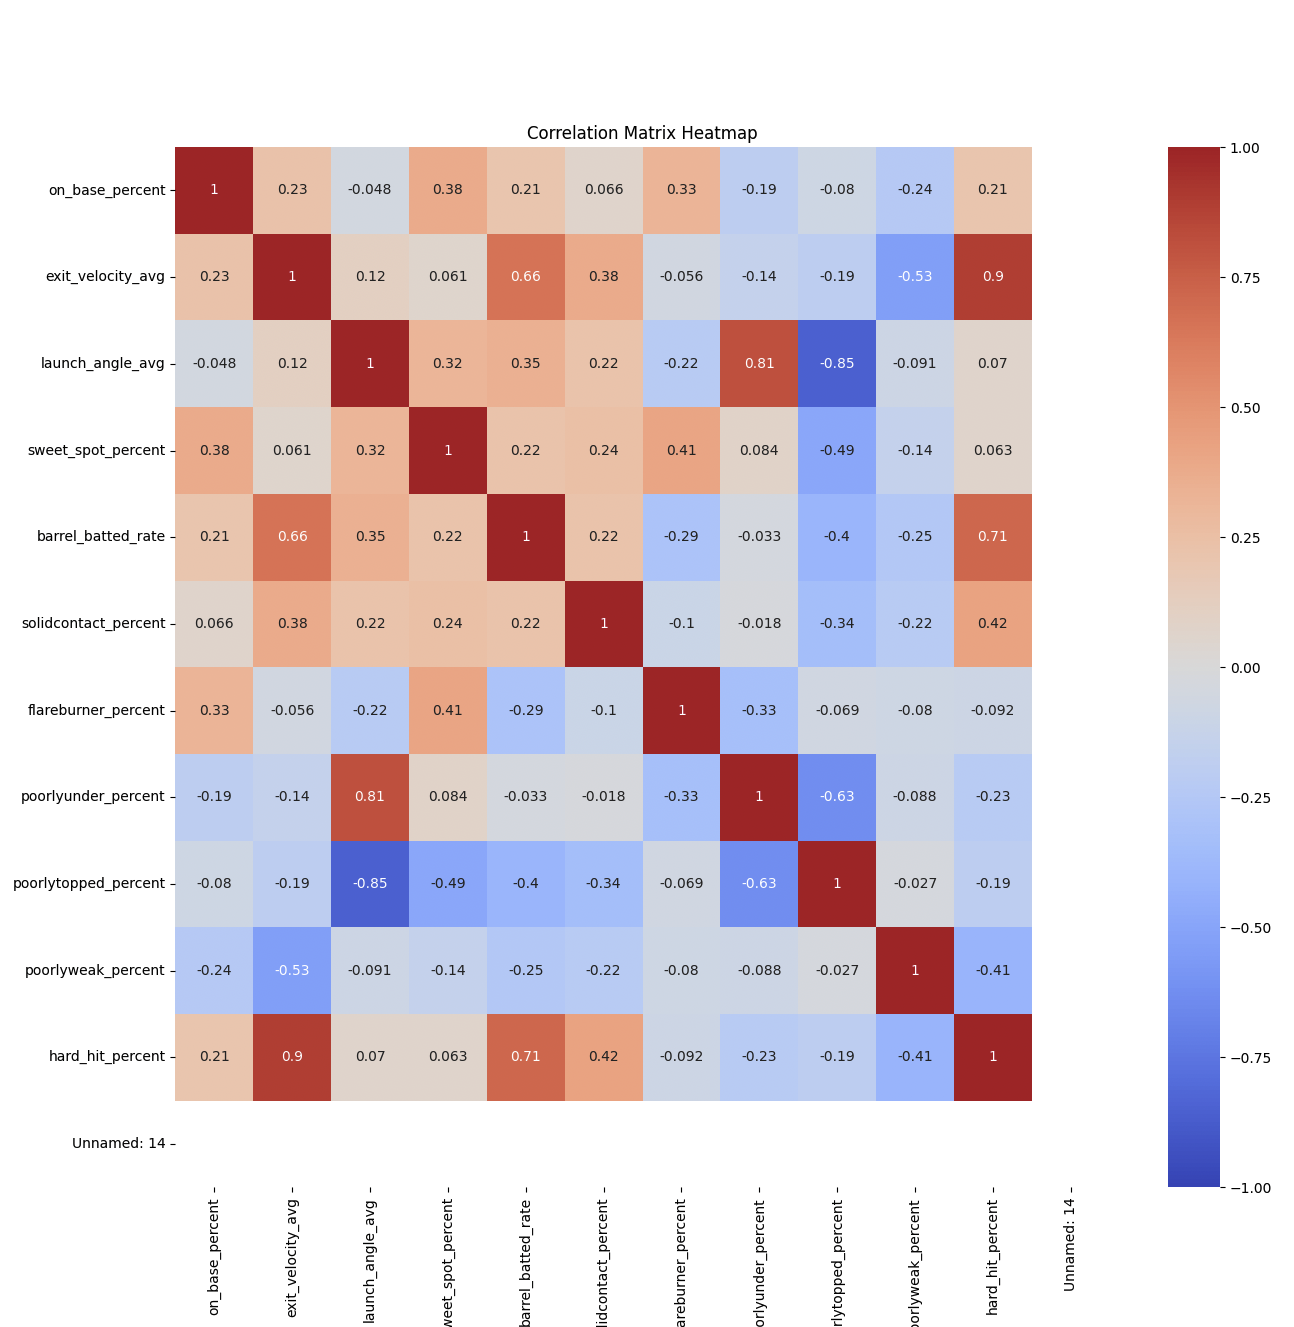

We don't have contributing value to OBP in the batted ball profile above .38, therefore none of the batted ball variables show a significant postive correlation to On Base Percentage. After our hypothesis testing, we find the best indicator for future OBP is not a specific batted ball variable, and one year to the next's production, but consistent production over the years. Therefore, we designate that as our training variable for our model. 

In choosing the model we have several options, collecting research on projects that utilize similar parameters: Using stackoverflow.com & github.com, we're shows us two that stand out: random forest & ridge regression. Why? After researching similiar projects and their limitations (https://github.com/search?q=Predicting+OBP+baseball&type=repositories), both ridge regression and Random Forest account for the type of decision structure we're looking for (tree based ML algs). We're going to test both and select the model with the least mean error. 

![Screenshot 2023-10-16 at 12.57.17 PM.png](<attachment:Screenshot 2023-10-16 at 12.57.17 PM.png>)
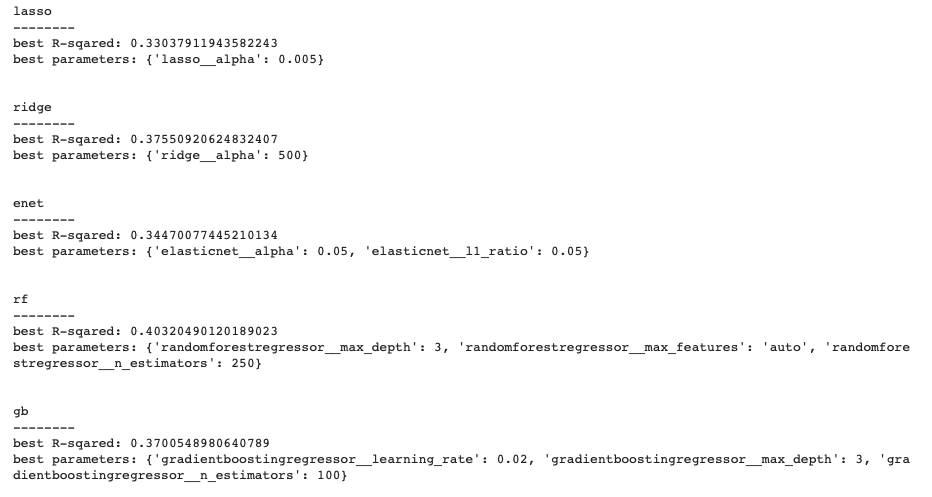

In [ ]:
#Ridge Regression

import pandas as pd
import numpy as np
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

df = pd.read_csv('/Users/rohitkrishnan/Desktop/obp.csv')

# Null value handling
for index, row in df.iterrows():
    df.loc[index] = row.fillna(row[['OBP_21', 'OBP_20', 'OBP_19', 'OBP_18', 'OBP_17', 'OBP_16']].mean())

#More null value handling
if df.isnull().sum().sum() == 0:
    pass
else:
    raise ValueError("There are still some NaN values.")

# Current columns and projection variale
X = df[['PA_21', 'PA_20', 'OBP_20', 'PA_19', 'OBP_19', 'PA_18', 'OBP_18', 'PA_17', 'OBP_17', 'PA_16', 'OBP_16']]
y = df['Predicted_OBP_21']

# Train the Ridge Regression Model
ridge = Ridge(alpha=1.0)  # You can adjust the alpha parameter for regularization
ridge.fit(X, y)

# Predict the 'Predicted_OBP_21'
predictions = ridge.predict(X)
df['Predicted_OBP_21'] = predictions

# Calculate the Mean Absolute Error (MAE)
mae = mean_absolute_error(df['OBP_21'], df['Predicted_OBP_21'])

print(f"Mean Absolute Error (MAE) between Actual and Predicted OBP: {mae:.4f}")

In [ ]:
# Random Forest 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

# Load the data
df = pd.read_csv('/Users/rohitkrishnan/Desktop/obp.csv')

#Cleaning null values
for index, row in df.iterrows():
    df.loc[index] = row.fillna(row[['OBP_21', 'OBP_20', 'OBP_19', 'OBP_18', 'OBP_17', 'OBP_16']].mean())

if df.isnull().sum().sum() == 0:
    pass
else:
    raise ValueError("There are still some NaN values.")

X = df[['PA_21', 'PA_20', 'OBP_20', 'PA_19', 'OBP_19', 'PA_18', 'OBP_18', 'PA_17', 'OBP_17', 'PA_16', 'OBP_16']]
y = df['Predicted_OBP_21']

# Train the Random Forest Model
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X, y)

# Predicting our 21 OBP
predictions = rf.predict(X)
df['Predicted_OBP_21'] = predictions
df.to_csv('/Users/rohitkrishnan/Desktop/obp.csv', index=False)

def plot_obp_data(player_data):
    years = ['2016', '2017', '2018', '2019', '2020', '2021']
    obp_values = [player_data.iloc[0]['OBP_16'], player_data.iloc[0]['OBP_17'],
                  player_data.iloc[0]['OBP_18'], player_data.iloc[0]['OBP_19'],
                  player_data.iloc[0]['OBP_20'], player_data.iloc[0]['OBP_21']]

    #looping over prior obps
    last_index = len(obp_values) - 1
    for i in range(len(obp_values) - 2, -1, -1):
        if obp_values[i] != obp_values[-1]:
            last_index = i
            break

    """ 
    Note: We don't need a scatter plot, but i just want a visualization to make sure 
    values look correct based on old values since we're wrighting to the file. Keep in
    mind since we have a matrix shape preserving code stipulation here players who debuted 
    after 2016 will have repeats.
    """

    plt.scatter(years[:last_index+1], obp_values[:last_index+1], label='Actual OBP', marker='o', color='blue')
    #Predicted 2021 OBP in red
    plt.scatter('2021', player_data.iloc[0]['Predicted_OBP_21'], label='Predicted OBP', marker='o', color='red')
    #OBP for 2021 in blue
    plt.scatter('2021', player_data.iloc[0]['OBP_21'], marker='o', color='blue')
    plt.title(f"{lookup_name} - OBP Over the Years")
    plt.xlabel('Year')
    plt.ylabel('OBP')
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.legend()
    plt.show()


# Player lookup. 
lookup_name = input("Enter the player's name to look up: ")
player_data = df[df['Name'] == lookup_name]

if len(player_data) == 0:
    print(f"Player '{lookup_name}' not found in the dataset.")
else:
    plot_obp_data(player_data)

#Mean Absolute Error
mae = mean_absolute_error(df['OBP_21'], df['Predicted_OBP_21'])

print(f"Mean Absolute Error (MAE) between Actual and Predicted OBP: {mae:.4f}")

def regression_check():
    # Actual vs predicted 2021 OBP values
    actual_obp_2021 = df['OBP_21']
    predicted_obp_2021 = df['Predicted_OBP_21']

    #R-squared value
    r2 = r2_score(actual_obp_2021, predicted_obp_2021)

    #Scatter plot
    plt.scatter(actual_obp_2021, predicted_obp_2021, alpha=0.5)
    plt.title(f'R-squared Linear Regression (Actual vs. Predicted 2021 OBP)\nR-squared = {r2:.4f}')
    plt.xlabel('Actual 2021 OBP')
    plt.ylabel('Predicted 2021 OBP')

    #LinReg
    model = LinearRegression()
    model.fit(actual_obp_2021.values.reshape(-1, 1), predicted_obp_2021)
    x = np.linspace(min(actual_obp_2021), max(actual_obp_2021), 100)
    y = model.predict(x.reshape(-1, 1))
    plt.plot(x, y, color='red')

    plt.grid(True)
    plt.show()
regression_check()

After testing: Ridge regression consistently has mean absolute error scores in the .031 range, while Random Forest is consistently in the .030 range. Therefore, we will utilize our Random Forest model, have already handled our user use case (input) and run our regression check. Now we can run the script, and now our predicted values will be appended to the source file we used for further use. 

**Motivation for Random Forest:**

Bayesian Modeling could be used here, but after finding the nature of our intrinically linked variables to be negligent, we realized the only past predictor of success for the 25% to the 75% x level of player (OBP being our x) is their prior success at getting on base. 

**Limitations:**

With 100 trials being articulated in Random Forest, and a mean error of around .030-.031 I am confident in the inherent abilites of our model. How we handled a multitide of NaN values were to create a matrix of averages from a player's prior data to replace Nan values if encountered, this preserved the shape of our model, as well as created fair distribution that allowed for accurate forecasting. The limitation of this? If age is a major factor in forecasting OBP, the model currently treats age as 1:1, meaning 35 is the same as 25, which can be further extrapolated on using a decay parameter in order to forecast even more accurately. 